In [27]:
pip install pandas scikit-learn krippendorff


Note: you may need to restart the kernel to use updated packages.


In [28]:
import pandas as pd
import krippendorff
from sklearn.metrics import cohen_kappa_score
import numpy as np

# Load CSV 
df = pd.read_csv("Cleaned_Long-Format_Scores.csv")

# Define human raters
human_raters = ['AS', 'YT', 'SY']

# Prepare data for Krippendorff's alpha
df_human = df[df['Rater'].isin(human_raters)]
df_pivot = df_human.pivot_table(index=['Feedback ID', 'Trait'], columns='Rater', values='Score')
alpha_data = df_pivot.transpose().values

# Compute Krippendorff's alpha
kripp_alpha = krippendorff.alpha(reliability_data=alpha_data, level_of_measurement='nominal')

# Compute majority vote among humans
def majority_vote(group):
    scores = group[group['Rater'].isin(human_raters)]['Score']
    return scores.mode().iloc[0] if not scores.mode().empty else np.nan

majority_votes = (
    df[df['Rater'].isin(human_raters)]
    .groupby(['Feedback ID', 'Trait'], group_keys=False)
    .apply(majority_vote)
    .reset_index(name='Human Majority')
)
ai_scores = df[df['Rater'] == 'AI'][['Feedback ID', 'Trait', 'Score']].rename(columns={'Score': 'AI Score'})

comparison_df = pd.merge(majority_votes, ai_scores, on=['Feedback ID', 'Trait']).dropna()

# Compute Cohen's kappa
cohen_kappa = cohen_kappa_score(comparison_df['Human Majority'], comparison_df['AI Score'])

print("Krippendorff's Alpha:", kripp_alpha)
print("Cohen's Kappa:", cohen_kappa)


Krippendorff's Alpha: 0.575399390525441
Cohen's Kappa: 0.7377185678601166


/var/folders/ny/shyzcqtd1mq92rgmzrlg_yl40000gn/T/ipykernel_2478/2572266895.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(majority_vote)


,Trait,Krippendorff’s Alpha,Avg. Pairwise Kappa,% Agreement
0,Communicative Clarity,0.60,0.58,70.0
1,Performance-Linked Specificity,0.60,0.58,70.0
2,Constructive Tone,0.86,0.86,90.0
3,Actionable Suggestions,0.87,0.87,90.0
4,Performance-Based Accuracy,-0.15,-0.17,30.0
5,Rubric-Based Accuracy,0.35,0.38,50.0
6,Student Learning,0.72,0.73,80.0


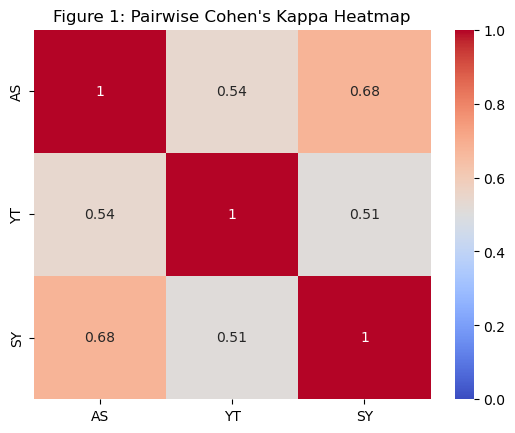

In [31]:
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

# Table 1
traits = df['Trait'].unique()
table1 = []

for trait in traits:
    trait_data = df[(df['Trait'] == trait) & (df['Rater'].isin(human_raters))]
    pivot = trait_data.pivot(index='Feedback ID', columns='Rater', values='Score')

    # Krippendorff
    alpha_data = pivot.transpose().values
    alpha = krippendorff.alpha(reliability_data=alpha_data, level_of_measurement='nominal')

    # Avg pairwise Cohen’s Kappa
    kappas = []
    for r1, r2 in itertools.combinations(human_raters, 2):
        if r1 in pivot.columns and r2 in pivot.columns:
            common = pivot[[r1, r2]].dropna()
            if not common.empty:
                kappas.append(cohen_kappa_score(common[r1], common[r2]))
    avg_kappa = np.mean(kappas) if kappas else np.nan

    # % Agreement
    def agreement(row): return 1 if len(row.dropna().unique()) == 1 else 0
    agreement_pct = pivot.apply(agreement, axis=1).mean() * 100

    table1.append([trait, round(alpha, 2), round(avg_kappa, 2), round(agreement_pct, 1)])

df_table1 = pd.DataFrame(table1, columns=["Trait", "Krippendorff’s Alpha", "Avg. Pairwise Kappa", "% Agreement"])
display(df_table1)

# Figure 1 
pairwise_matrix = pd.DataFrame(index=human_raters, columns=human_raters, dtype=float)

for r1, r2 in itertools.combinations(human_raters, 2):
    common = df[df['Rater'].isin([r1, r2])]
    pivot = common.pivot_table(index=['Feedback ID', 'Trait'], columns='Rater', values='Score').dropna()
    if not pivot.empty:
        kappa = cohen_kappa_score(pivot[r1], pivot[r2])
        pairwise_matrix.loc[r1, r2] = pairwise_matrix.loc[r2, r1] = kappa

np.fill_diagonal(pairwise_matrix.values, 1.0)
sns.heatmap(pairwise_matrix.astype(float), annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title("Figure 1: Pairwise Cohen's Kappa Heatmap")
plt.show()


In [33]:
traits = df['Trait'].unique()
table2_all = []

for trait in traits:
    # Filter by trait
    human_trait = majority_votes[majority_votes['Trait'] == trait]
    ai_trait = ai_scores[ai_scores['Trait'] == trait]
    merged = pd.merge(human_trait, ai_trait, on=['Feedback ID', 'Trait']).dropna()
    
    # Calculate agreement
    if not merged.empty:
        kappa = cohen_kappa_score(merged['Human Majority'], merged['AI Score'])
        match_pct = (merged['Human Majority'] == merged['AI Score']).mean() * 100
        table2_all.append([trait, round(kappa, 2), round(match_pct, 1)])

# Create and display table
df_table2_all = pd.DataFrame(table2_all, columns=["Trait", "Cohen’s Kappa", "% Match with Consensus"])
display(df_table2_all)


,Trait,Cohen’s Kappa,% Match with Consensus
0,Communicative Clarity,0.60,80.0
1,Performance-Linked Specificity,1.00,100.0
2,Constructive Tone,1.00,100.0
3,Actionable Suggestions,1.00,100.0
4,Performance-Based Accuracy,0.20,60.0
5,Rubric-Based Accuracy,0.60,80.0
6,Student Learning,0.78,90.0
